# Trabajo Práctico III - Ejercicio 1
### Fernando Ezequiel pose

## Librerías Generales

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Procesamiento de archivos
import os
from shutil import copyfile
import random

# Otras
import time

## Preparación de los datos

In [2]:
# Descargo el dataset
!wget -c --no-check-certificate "https://drive.google.com/uc?export=download&id=1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR&confirm=t" -O partes_mecanicas.zip
# Descomprimo el archivo partes_mecanicas.zip
!unzip -qq partes_mecanicas.zip

--2023-11-26 17:42:32--  https://drive.google.com/uc?export=download&id=1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR&confirm=t
Resolving drive.google.com (drive.google.com)... 142.251.2.102, 142.251.2.113, 142.251.2.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g04iolkp6m44771jusrbuufh46odmr4u/1701020550000/12225850433951268217/*/1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR?e=download&uuid=90042b29-c3a3-488b-b686-e7dd0d28fd55 [following]
--2023-11-26 17:42:33--  https://doc-0k-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g04iolkp6m44771jusrbuufh46odmr4u/1701020550000/12225850433951268217/*/1nZOYJbLXEQbuUkmkMO4I2IIFQUjfKYBR?e=download&uuid=90042b29-c3a3-488b-b686-e7dd0d28fd55
Resolving doc-0k-9c-docs.googleusercontent.com (doc-0k-9c-docs.googleusercontent.com)... 142.251.2.132, 

In [3]:
def explora_dir(directory_name):
    for dirpaths, dirnames, filenames in os.walk(directory_name):
        print(f"Existen {len(dirnames)} directorios y {len(filenames)} imágenes en '{dirpaths}'")

In [4]:
dir_datos = './partes_mecanicas'
explora_dir(dir_datos)

Existen 4 directorios y 0 imágenes en './partes_mecanicas'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/tornillo'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/tuerca'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/pasador'
Existen 0 directorios y 1904 imágenes en './partes_mecanicas/arandela'


### Subvivisión del dataset

In [5]:
os.mkdir('./data')
os.mkdir('./data/train')
os.mkdir('./data/test')
for folder in os.listdir(dir_datos):
    files=os.listdir(os.path.join(dir_datos, folder))
    images=[]
    for f in files:
        try:
            img=tf.io.read_file(os.path.join(dir_datos, folder,f))
            img=tf.image.decode_image(img)
            images.append(f)
        except:
               pass


    random.shuffle(images)
    count=len(images)
    split=int(0.8*count)    # 80% de los datos para test
    os.mkdir(os.path.join('./data/train', folder))
    os.mkdir(os.path.join('./data/test', folder))

    for c in range(split):
        source_file=os.path.join(dir_datos, folder, images[c])
        distination=os.path.join('./data/train', folder, images[c])
        copyfile(source_file, distination)
    for c in range(split,count):
        source_file=os.path.join(dir_datos, folder, images[c])
        distination=os.path.join('./data/test', folder, images[c])
        copyfile(source_file, distination)

In [6]:
dir_train = './data/train'
explora_dir(dir_train)

Existen 4 directorios y 0 imágenes en './data/train'
Existen 0 directorios y 1523 imágenes en './data/train/tornillo'
Existen 0 directorios y 1523 imágenes en './data/train/tuerca'
Existen 0 directorios y 1523 imágenes en './data/train/pasador'
Existen 0 directorios y 1523 imágenes en './data/train/arandela'


In [7]:
dir_test = './data/test'
explora_dir(dir_test)

Existen 4 directorios y 0 imágenes en './data/test'
Existen 0 directorios y 381 imágenes en './data/test/tornillo'
Existen 0 directorios y 381 imágenes en './data/test/tuerca'
Existen 0 directorios y 381 imágenes en './data/test/pasador'
Existen 0 directorios y 381 imágenes en './data/test/arandela'


In [8]:
def plot_random_image(target_dir):
    """
    Toma el directorio como entrada e imprime 5 imágenes aleatorias de una de las subcarpetas.
    """
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),5)

    plt.figure(figsize=(16,5))
    for i in range(5):

        plt.subplot(1,5,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}\n{img.shape}')
        plt.axis(False)

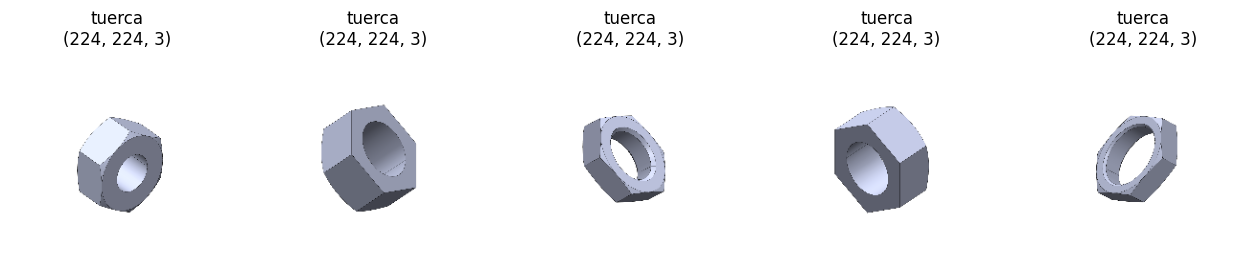

In [9]:
plot_random_image(dir_train)

### Preparación de los lotes

In [10]:
IMAGE_SIZE = (224, 224) # Permite reescalar el preprocesador de keras

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)

class_names = train_data.class_names    # Para traducir la codificación en enteros
num_classes = len(class_names)          # Para fijar en la capa de salida

test_data=tf.keras.preprocessing.image_dataset_from_directory(
    dir_test,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

Found 6092 files belonging to 4 classes.
Found 1524 files belonging to 4 classes.


## Armado del Modelo

### CRNA - modelo y parámetros

In [11]:
# Función para configurar el guardado de los pesos a medida que se va entrenando
def create_model_check_point_callback(checkpoint_path, monitor='val_loss'):
    """
    Toma el camino donde guardar los mejores pesos modelo obtenidos durante el entrenamiento.
    """
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb

In [12]:
# Criterio de parada extra, épocas que espera sin mejorar para detener entrenamiento
earlystop = EarlyStopping(patience=5)

# Ajuste de tasa de aprendizaje automático
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)


ModelCheckPoint_model_cb = create_model_check_point_callback('./ModelCheckPoints/model.ckpt')

In [13]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))       # Importante, input_shape debe ser el tamaño de las imágenes (alto, ancho, canales)
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())      #Flatten, se utiliza para pasar de 2D a 1D en este caso.
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3

### Entrenamiento

In [14]:
start_entrenamiento = time.time()

# Entreno el modelo
history = model.fit(train_data, epochs=50, batch_size=300, validation_data=test_data, callbacks=[earlystop, learning_rate_reduction, ModelCheckPoint_model_cb])

fin_entrenamiento = time.time()

Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 4.3903 - accuracy: 0.6797
Epoch 1: val_loss improved from inf to 0.38252, saving model to ./ModelCheckPoints/model.ckpt
191/191 [==============================] - 28s 87ms/step - loss: 4.3903 - accuracy: 0.6797 - val_loss: 0.3825 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 2/50
190/191 [============================>.] - ETA: 0s - loss: 0.3849 - accuracy: 0.8691
Epoch 2: val_loss improved from 0.38252 to 0.21712, saving model to ./ModelCheckPoints/model.ckpt
191/191 [==============================] - 17s 89ms/step - loss: 0.3844 - accuracy: 0.8693 - val_loss: 0.2171 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 3/50
190/191 [============================>.] - ETA: 0s - loss: 0.3079 - accuracy: 0.8926
Epoch 3: val_loss improved from 0.21712 to 0.18105, saving model to ./ModelCheckPoints/model.ckpt
191/191 [==============================] - 16s 81ms/step - loss: 0.3074 - accuracy: 0.8928 - val_loss: 0.1810 - val_accuracy: 0.94

## Evaluación de resultados

In [16]:
def plot_curves(history):
    '''
    Devuelve curvas de loss u accuracy, separadas para métricas de entrenamiento y validación.
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Pérdida en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Precisión en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()



# Función para graficar como imagen la matriz de confusión
def plot_confusion_matrix(y_true, y_preds, labels=None, model_name=None, normalize=None):
    """
    Función para graficar la Matrix de confusión
    y_true: vector de salida real
    y_predic: vector de salida predicho por el modelo
    labels: opcional, para nombrar las clases. Lista con strings
    model_name: opcional, para poner un título al gráfico
    normalize: {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    """
    if normalize:
        cm = confusion_matrix(y_true, y_preds, normalize=normalize)
    else:
        cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()
    cmd.ax_.set(xlabel='Clase Predicha', ylabel='Clase Real')
    if model_name:
        cmd.ax_.set(title=model_name)


def load_and_prep_image(filename, img_shape=224, scale=True):
    '''
    lee una imagen del nombre del archivo y la convierte en un tensor,
    y lo remodela al tamaño especificado.

    argumentos:
    filename: ruta a la imagen de destino.
    scale(boolean): especifica si es necesario escalar o no.

    devoluciones:
    tensor de imagen con la forma objetivo.
    '''
    img=tf.io.read_file(filename)
    img=tf.io.decode_image(img, channels=3)
    img=tf.image.resize(img,size=[img_shape,img_shape])

    if scale:
        img=img/255.0
    return img

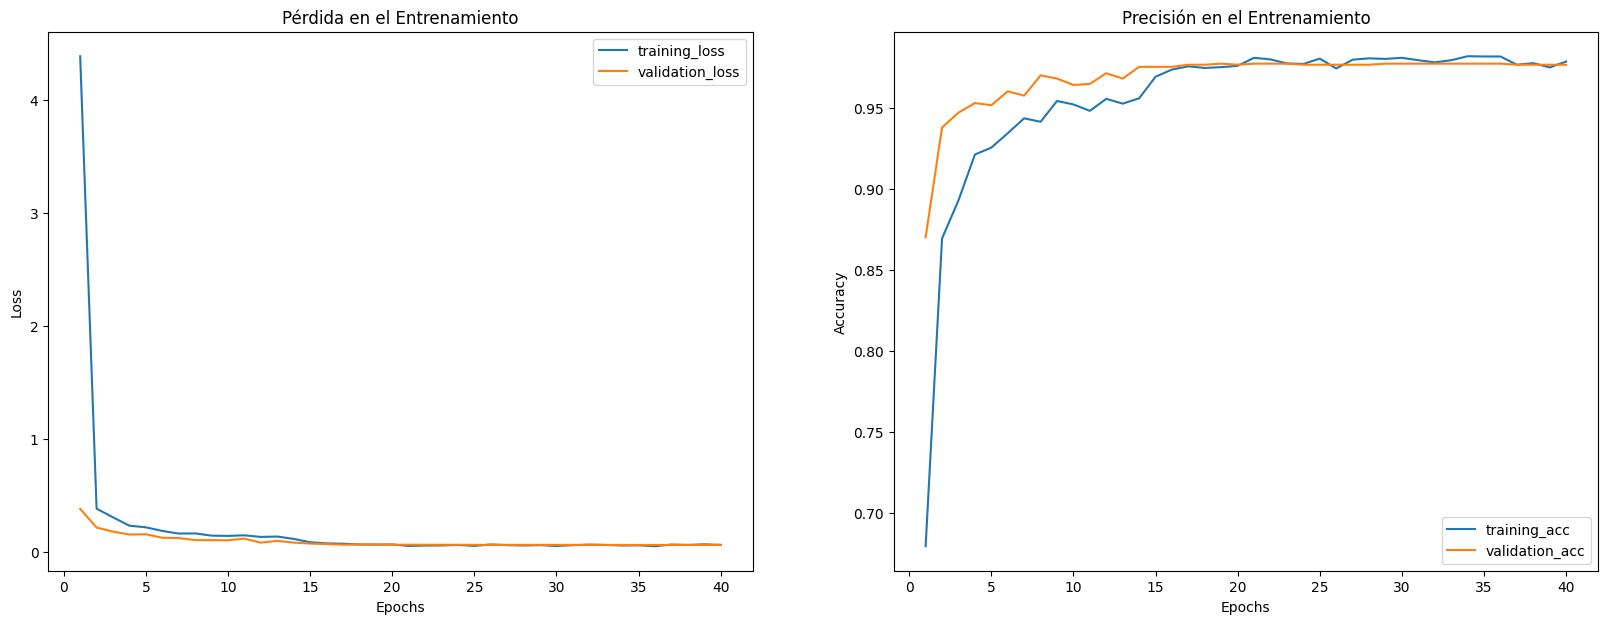

In [17]:
plot_curves(history)

In [18]:
model_result = model.evaluate(test_data)
model_result

48/48 [==============================] - 1s 25ms/step - loss: 0.0630 - accuracy: 0.9764


[0.06295030564069748, 0.9763779640197754]

In [19]:
start_predict = time.time()
y_pred = model.predict(test_data)
end_predict = time.time()

48/48 [==============================] - 2s 33ms/step


In [20]:
def predict_class(y_pred):
    y_class = []
    for i in y_pred:
        y_class.append(int(np.where(i == np.amax(i))[0]))

    return np.array(y_class)

In [21]:
# Conversión a la clase más probable
y_pred_class = predict_class(y_pred)

In [22]:
# Conversión de las clases reales
y_labels = []
for _,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())

In [23]:
filepaths = []
for filepath in test_data.list_files(dir_test+'/*/*.png',shuffle=False):
    filepaths.append(filepath.numpy())

In [24]:
# Se crea un dataframe con información relacionada a las predicciones
pred_df=pd.DataFrame({
    'filepaths':filepaths,
    'y_true':y_labels,
    'y_pred':y_pred_class,
    'pred_conf':y_pred.max(axis=1),
    'actual_class_name':[class_names[i] for i in y_labels],
    'pred_class_name':[class_names[i] for i in y_pred_class]
     })
pred_df.head()

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'./data/test/arandela/30W_1003N_10.png',0,0,0.982434,arandela,arandela
1,b'./data/test/arandela/30W_1003N_14.png',0,0,0.717917,arandela,arandela
2,b'./data/test/arandela/30W_1003N_5.png',0,0,0.974022,arandela,arandela
3,b'./data/test/arandela/30W_2505_19.png',0,0,0.999938,arandela,arandela
4,b'./data/test/arandela/30W_2505_20.png',0,0,0.999979,arandela,arandela


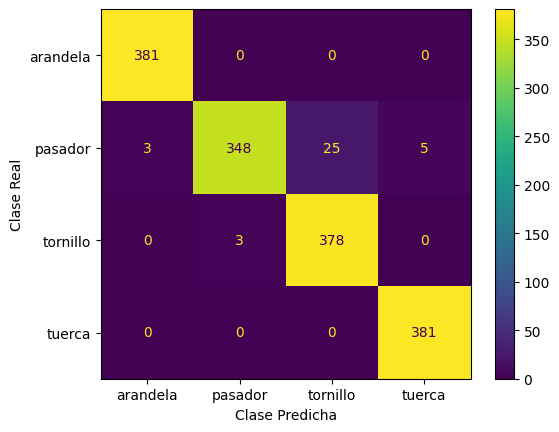

In [25]:
plot_confusion_matrix(pred_df['y_true'], pred_df['y_pred'], labels=class_names)


In [26]:
print(classification_report(pred_df['y_true'], pred_df['y_pred']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       381
           1       0.99      0.91      0.95       381
           2       0.94      0.99      0.96       381
           3       0.99      1.00      0.99       381

    accuracy                           0.98      1524
   macro avg       0.98      0.98      0.98      1524
weighted avg       0.98      0.98      0.98      1524



In [27]:
class_names

['arandela', 'pasador', 'tornillo', 'tuerca']

In [28]:
# Se filtran las imágenes que no ha podido clasificar correctamente
pred_wrong_df = pred_df[pred_df['y_true']!=pred_df['y_pred']].reset_index(drop=True)
pred_wrong_df.head()

,filepaths,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
0,b'./data/test/pasador/FLPDC12-L23-P16_10.png',1,3,0.969023,pasador,tuerca
1,b'./data/test/pasador/FLPDC12-L23-P16_4.png',1,3,0.900805,pasador,tuerca
2,b'./data/test/pasador/FLPDQ16-L23-P20_15.png',1,3,0.597869,pasador,tuerca
3,b'./data/test/pasador/IPTA3-D10_15.png',1,0,0.592318,pasador,arandela
4,b'./data/test/pasador/IPTA3-D10_9.png',1,0,0.965580,pasador,arandela


In [30]:
pred_wrong_df.shape

(36, 6)

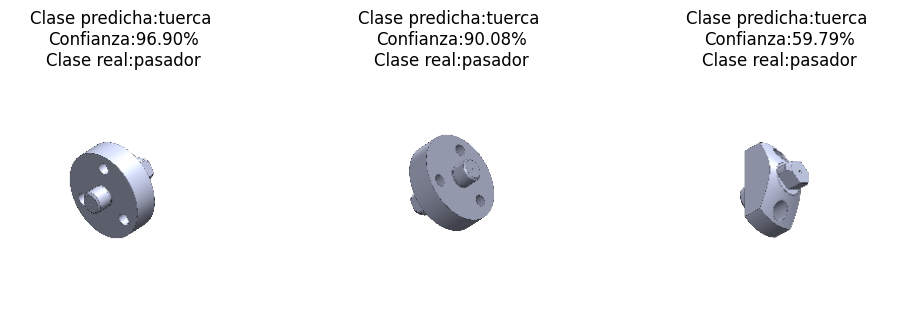

In [31]:
# Visualizar imágenes en las que se equivocó
images_to_view = 3  # Cantidad
start_index = 0     # Desde dónde comienza del df
plt.figure(figsize=(12,10))
for i,row in enumerate(pred_wrong_df[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img=load_and_prep_image(row[1],scale=False)
    _,_,_,_,pred_p,act_cls,prd_cls=row
    plt.imshow(img/255.0)
    plt.title(f"Clase predicha:{prd_cls} \nConfianza:{pred_p*100:.2f}%\nClase real:{act_cls}")
    plt.axis(False)

## Evaluar una imagen cualquiera con la red

In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [33]:
image = load_img('./data/test/arandela/30W_1003N_14.png', target_size=(224,224))
image = img_to_array(image)
prediction_image = np.array(image)
prediction_image = np.expand_dims(image, axis=0)

In [34]:
start_predict_nueva_imagen = time.time()
img_pred = model.predict(prediction_image)
end_predict_nueva_imagen = time.time()

1/1 [==============================] - 0s 198ms/step


In [37]:
img_pred

array([[0.71791667, 0.11869533, 0.00247875, 0.16090922]], dtype=float32)

In [38]:
img_pred.max(axis=1)    # Confianza con la que escogió la clase

array([0.71791667], dtype=float32)

In [39]:
class_names[predict_class(img_pred)[0]]     # Nombre de la clase

'arandela'

In [40]:
class_names

['arandela', 'pasador', 'tornillo', 'tuerca']

### TIEMPOS

In [41]:
print("Tiempo de entrenamiento: {:.4f} s".format(fin_entrenamiento-start_entrenamiento))
print("Tiempo de predicción del dataset: {:.4f} s".format(end_predict-start_predict))
print("Tiempo de predicción de una imagen: {:.4f} s".format(end_predict_nueva_imagen-start_predict_nueva_imagen))

Tiempo de entrenamiento: 717.6690 s
Tiempo de predicción del dataset: 1.7765 s
Tiempo de predicción de una imagen: 0.2474 s
